# Enhanced LSTM Location Order Prediction Model with Additional Features
# This notebook uses LSTM to predict the picking order with temporal and spatial features

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional, Concatenate, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.20.0
GPU Available: []


# ==================== STEP 1: Load and Explore Data ====================

In [4]:
print("\n" + "=" * 60)
print("STEP 1: Loading Data")
print("=" * 60)

# Load the CSV file
df = pd.read_csv('newTestingData.csv')

print(f"\nDataset Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head(10))

print("\nColumn Names:")
print(df.columns.tolist())

print("\nData Types:")
print(df.dtypes)

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nUnique Values:")
print(f"Unique Customer Orders: {df['CUST_ORDER_ID'].nunique()}")
print(f"Unique Locations: {df['LOCATION_ID'].nunique()}")
print(f"Unique Parts: {df['PART_ID'].nunique()}")
print(f"Unique Zones: {df['ZONE'].nunique() if 'ZONE' in df.columns else 'N/A'}")
print(f"Location Ranks: {df['LOCATION_RANK'].min()} to {df['LOCATION_RANK'].max()}")


STEP 1: Loading Data

Dataset Shape: (4205, 18)

First few rows:
  CUST_ORDER_ID LOCATION_ID     PART_ID TYPE  QTY         TRANSACTION_DATE  \
0        015619    D4000000  1097062059    O  2.0  2009-04-20 00:00:00.000   
1        015619    D4000000  1081104001    O  1.0  2009-04-20 00:00:00.000   
2        015619    D6000000  1040021101    O  5.0  2009-04-20 00:00:00.000   
3        015619    D7000000  1010333101    O  5.0  2009-04-20 00:00:00.000   
4        015619    D8358900  1097082009    O  2.0  2009-04-20 00:00:00.000   
5      013067-1    D4000000  1083341001    O  1.0  2009-04-20 00:00:00.000   
6        015616    E7467900  1412051001    O  1.0  2009-04-20 00:00:00.000   
7        015398    F7000000  1030076013    O  2.0  2009-04-21 00:00:00.000   
8        015398    D8348400  1018003001    O  4.0  2009-04-21 00:00:00.000   
9        015398    D4000000  1019093101    O  1.0  2009-04-21 00:00:00.000   

               CREATE_DATE USER_ID  PICK_HOUR  DAY_OF_WEEK ZONE AISLE_BIN  

# ==================== STEP 2: Feature Engineering ====================

In [5]:
print("\n" + "=" * 60)
print("STEP 2: Feature Engineering")
print("=" * 60)

# Convert dates to datetime
df['CREATE_DATE'] = pd.to_datetime(df['CREATE_DATE'])
df['TRANSACTION_DATE'] = pd.to_datetime(df['TRANSACTION_DATE'])

# Extract additional features from existing data if not present
if 'PICK_HOUR' not in df.columns:
    df['PICK_HOUR'] = df['CREATE_DATE'].dt.hour
    print("✓ Created PICK_HOUR from CREATE_DATE")

if 'DAY_OF_WEEK' not in df.columns:
    df['DAY_OF_WEEK'] = df['CREATE_DATE'].dt.dayofweek
    print("✓ Created DAY_OF_WEEK from CREATE_DATE")

if 'ZONE' not in df.columns:
    df['ZONE'] = df['LOCATION_ID'].str[0]
    print("✓ Extracted ZONE from LOCATION_ID")

if 'AISLE_BIN' not in df.columns:
    df['AISLE_BIN'] = df['LOCATION_ID'].str[1:]
    print("✓ Extracted AISLE_BIN from LOCATION_ID")

# Handle ORDER_SIZE if not present
if 'ORDER_SIZE' not in df.columns:
    df['ORDER_SIZE'] = df.groupby('CUST_ORDER_ID')['LOCATION_ID'].transform('count')
    print("✓ Calculated ORDER_SIZE")

# Handle TOTAL_ORDER_QTY if not present
if 'TOTAL_ORDER_QTY' not in df.columns:
    df['TOTAL_ORDER_QTY'] = df.groupby('CUST_ORDER_ID')['QTY'].transform('sum')
    print("✓ Calculated TOTAL_ORDER_QTY")

# Create sequential features if not present
if 'PREV_LOCATION' not in df.columns:
    df = df.sort_values(['CUST_ORDER_ID', 'CREATE_DATE'])
    df['PREV_LOCATION'] = df.groupby('CUST_ORDER_ID')['LOCATION_ID'].shift(1)
    print("✓ Created PREV_LOCATION")

if 'NEXT_LOCATION' not in df.columns:
    df['NEXT_LOCATION'] = df.groupby('CUST_ORDER_ID')['LOCATION_ID'].shift(-1)
    print("✓ Created NEXT_LOCATION")

# Calculate time between picks if not present
if 'SECONDS_SINCE_LAST_PICK' not in df.columns:
    df['SECONDS_SINCE_LAST_PICK'] = df.groupby('CUST_ORDER_ID')['CREATE_DATE'].diff().dt.total_seconds()
    df['SECONDS_SINCE_LAST_PICK'] = df['SECONDS_SINCE_LAST_PICK'].fillna(0)
    print("✓ Calculated SECONDS_SINCE_LAST_PICK")

# Calculate location average rank if not present
if 'LOCATION_AVG_RANK' not in df.columns:
    df['LOCATION_AVG_RANK'] = df.groupby('LOCATION_ID')['LOCATION_RANK'].transform('mean')
    print("✓ Calculated LOCATION_AVG_RANK")

# Zone change indicator
df['ZONE_CHANGE'] = (df['ZONE'] != df.groupby('CUST_ORDER_ID')['ZONE'].shift(1)).astype(int)
df.loc[df.groupby('CUST_ORDER_ID').head(1).index, 'ZONE_CHANGE'] = 0

# Fill NaN values
df['PREV_LOCATION'] = df['PREV_LOCATION'].fillna('NONE')
df['NEXT_LOCATION'] = df['NEXT_LOCATION'].fillna('NONE')

print(f"\nTotal features after engineering: {df.shape[1]}")
print("\nFeature list:")
print(df.columns.tolist())


STEP 2: Feature Engineering
✓ Calculated LOCATION_AVG_RANK

Total features after engineering: 20

Feature list:
['CUST_ORDER_ID', 'LOCATION_ID', 'PART_ID', 'TYPE', 'QTY', 'TRANSACTION_DATE', 'CREATE_DATE', 'USER_ID', 'PICK_HOUR', 'DAY_OF_WEEK', 'ZONE', 'AISLE_BIN', 'ORDER_SIZE', 'TOTAL_ORDER_QTY', 'PREV_LOCATION', 'NEXT_LOCATION', 'SECONDS_SINCE_LAST_PICK', 'LOCATION_RANK', 'LOCATION_AVG_RANK', 'ZONE_CHANGE']


# ==================== STEP 3: Encode Categorical Variables ====================

In [6]:
print("\n" + "=" * 60)
print("STEP 3: Encoding Categorical Variables")
print("=" * 60)

# Label Encoders
le_location = LabelEncoder()
le_part = LabelEncoder()
le_zone = LabelEncoder()
le_user = LabelEncoder()
le_prev_loc = LabelEncoder()
le_next_loc = LabelEncoder()

df['LOCATION_ENCODED'] = le_location.fit_transform(df['LOCATION_ID'])
df['PART_ENCODED'] = le_part.fit_transform(df['PART_ID'])
df['ZONE_ENCODED'] = le_zone.fit_transform(df['ZONE'])
df['USER_ENCODED'] = le_user.fit_transform(df['USER_ID'])
df['PREV_LOCATION_ENCODED'] = le_prev_loc.fit_transform(df['PREV_LOCATION'])
df['NEXT_LOCATION_ENCODED'] = le_next_loc.fit_transform(df['NEXT_LOCATION'])

print(f"✓ Locations encoded: {len(le_location.classes_)} unique")
print(f"✓ Parts encoded: {len(le_part.classes_)} unique")
print(f"✓ Zones encoded: {len(le_zone.classes_)} unique")
print(f"✓ Users encoded: {len(le_user.classes_)} unique")

# Scale numerical features
scaler = StandardScaler()
numerical_features = ['QTY', 'ORDER_SIZE', 'TOTAL_ORDER_QTY', 'PICK_HOUR', 
                      'DAY_OF_WEEK', 'SECONDS_SINCE_LAST_PICK', 'LOCATION_AVG_RANK']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

print("✓ Numerical features scaled")


STEP 3: Encoding Categorical Variables
✓ Locations encoded: 575 unique
✓ Parts encoded: 336 unique
✓ Zones encoded: 7 unique
✓ Users encoded: 1 unique
✓ Numerical features scaled


# ==================== STEP 4: Create Sequences for LSTM ====================

In [7]:
print("\n" + "=" * 60)
print("STEP 4: Creating Sequences")
print("=" * 60)

# Sort by customer order and rank to maintain sequence
df = df.sort_values(['CUST_ORDER_ID', 'LOCATION_RANK'])

# Group by customer order
order_groups = df.groupby('CUST_ORDER_ID')
print(f"\nTotal orders: {len(order_groups)}")

# Analyze sequence lengths
sequence_lengths = order_groups.size()
print("\nSequence Length Statistics:")
print(sequence_lengths.describe())

# Create training data
X_sequences = []
X_features = []
y_ranks = []

for order_id, group in order_groups:
    group = group.sort_values('LOCATION_RANK')
    
    # Sequence features (for LSTM)
    location_seq = group['LOCATION_ENCODED'].values
    part_seq = group['PART_ENCODED'].values
    zone_seq = group['ZONE_ENCODED'].values
    
    # Additional features (for dense layers)
    for i in range(len(group)):
        row = group.iloc[i]
        
        # Sequence input
        X_sequences.append(list(zip(location_seq, part_seq, zone_seq)))
        
        # Additional features
        feature_vector = [
            row['QTY'],
            row['ORDER_SIZE'],
            row['TOTAL_ORDER_QTY'],
            row['PICK_HOUR'],
            row['DAY_OF_WEEK'],
            row['SECONDS_SINCE_LAST_PICK'],
            row['LOCATION_AVG_RANK'],
            row['ZONE_CHANGE'],
            row['ZONE_ENCODED'],
            row['USER_ENCODED'],
            row['PREV_LOCATION_ENCODED'],
            row['NEXT_LOCATION_ENCODED'],
            i  # Position in sequence
        ]
        X_features.append(feature_vector)
        
        # Target
        y_ranks.append(row['LOCATION_RANK'] - 1)  # 0-indexed

print(f"\nTotal training samples: {len(X_sequences)}")

# Separate sequence components
X_location_seq = [[item[0] for item in seq] for seq in X_sequences]
X_part_seq = [[item[1] for item in seq] for seq in X_sequences]
X_zone_seq = [[item[2] for item in seq] for seq in X_sequences]

# Pad sequences
max_sequence_length = max(len(seq) for seq in X_location_seq)
print(f"Maximum sequence length: {max_sequence_length}")

X_location_padded = pad_sequences(X_location_seq, maxlen=max_sequence_length, padding='post')
X_part_padded = pad_sequences(X_part_seq, maxlen=max_sequence_length, padding='post')
X_zone_padded = pad_sequences(X_zone_seq, maxlen=max_sequence_length, padding='post')
X_features = np.array(X_features)
y_ranks = np.array(y_ranks)

# Convert to categorical
num_ranks = len(np.unique(y_ranks))
print(f"Number of rank classes: {num_ranks}")
y_ranks_categorical = to_categorical(y_ranks, num_classes=num_ranks)

print(f"\nX_location shape: {X_location_padded.shape}")
print(f"X_part shape: {X_part_padded.shape}")
print(f"X_zone shape: {X_zone_padded.shape}")
print(f"X_features shape: {X_features.shape}")
print(f"y_ranks shape: {y_ranks_categorical.shape}")


STEP 4: Creating Sequences

Total orders: 777

Sequence Length Statistics:
count    777.000000
mean       5.411840
std        4.730659
min        1.000000
25%        1.000000
50%        4.000000
75%        8.000000
max       32.000000
dtype: float64

Total training samples: 4205
Maximum sequence length: 32
Number of rank classes: 32

X_location shape: (4205, 32)
X_part shape: (4205, 32)
X_zone shape: (4205, 32)
X_features shape: (4205, 13)
y_ranks shape: (4205, 32)


# ==================== STEP 5: Train-Test Split ====================

In [8]:
print("\n" + "=" * 60)
print("STEP 5: Splitting Data")
print("=" * 60)

# Split data
split_idx = int(0.8 * len(X_location_padded))

X_loc_train = X_location_padded[:split_idx]
X_loc_test = X_location_padded[split_idx:]

X_part_train = X_part_padded[:split_idx]
X_part_test = X_part_padded[split_idx:]

X_zone_train = X_zone_padded[:split_idx]
X_zone_test = X_zone_padded[split_idx:]

X_feat_train = X_features[:split_idx]
X_feat_test = X_features[split_idx:]

y_train = y_ranks_categorical[:split_idx]
y_test = y_ranks_categorical[split_idx:]

print(f"Training Set: {X_loc_train.shape[0]} samples")
print(f"Test Set: {X_loc_test.shape[0]} samples")


STEP 5: Splitting Data
Training Set: 3364 samples
Test Set: 841 samples


# ==================== STEP 6: Build Enhanced LSTM Model ====================

In [9]:
print("\n" + "=" * 60)
print("STEP 6: Building Enhanced LSTM Model")
print("=" * 60)

def create_enhanced_lstm_model(num_locations, num_parts, num_zones, max_len, 
                                num_features, num_classes, embedding_dim=50):
    """
    Create enhanced LSTM model with multiple inputs
    """
    # Input layers
    location_input = Input(shape=(max_len,), name='location_input')
    part_input = Input(shape=(max_len,), name='part_input')
    zone_input = Input(shape=(max_len,), name='zone_input')
    features_input = Input(shape=(num_features,), name='features_input')
    
    # Embedding layers
    location_embed = Embedding(num_locations + 1, embedding_dim)(location_input)
    part_embed = Embedding(num_parts + 1, embedding_dim)(part_input)
    zone_embed = Embedding(num_zones + 1, embedding_dim // 2)(zone_input)
    
    # Concatenate embeddings
    concat_embed = Concatenate()([location_embed, part_embed, zone_embed])
    
    # LSTM layers
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(concat_embed)
    dropout1 = Dropout(0.3)(lstm1)
    
    lstm2 = Bidirectional(LSTM(64, return_sequences=False))(dropout1)
    dropout2 = Dropout(0.3)(lstm2)
    
    # Combine LSTM output with additional features
    combined = Concatenate()([dropout2, features_input])
    
    # Dense layers
    dense1 = Dense(128, activation='relu')(combined)
    dropout3 = Dropout(0.2)(dense1)
    
    dense2 = Dense(64, activation='relu')(dropout3)
    dropout4 = Dropout(0.2)(dense2)
    
    # Output layer
    output = Dense(num_classes, activation='softmax', name='output')(dropout4)
    
    # Create model
    model = Model(
        inputs=[location_input, part_input, zone_input, features_input],
        outputs=output
    )
    
    return model

# Create model
lstm_model = create_enhanced_lstm_model(
    num_locations=len(le_location.classes_),
    num_parts=len(le_part.classes_),
    num_zones=len(le_zone.classes_),
    max_len=max_sequence_length,
    num_features=X_features.shape[1],
    num_classes=num_ranks,
    embedding_dim=50
)

# Compile model
lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
lstm_model.summary()


STEP 6: Building Enhanced LSTM Model

Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ location_input      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ part_input          │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zone_input          │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 32, 50)    │     28,800 │ location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 32, 50)    │     16,850 │ part_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 32, 25)    │        200 │ zone_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 125)   │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ embedding_1[0][0… │
│                     │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 32, 256)   │    260,096 │ concatenate[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_input      │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 141)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ features_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     18,176 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 32)        │      2,080 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 498,810 (1.90 MB)

 Trainable params: 498,810 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

# ==================== STEP 7: Train LSTM Model ====================

In [10]:
print("\n" + "=" * 60)
print("STEP 7: Training Enhanced LSTM Model")
print("=" * 60)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=0.00001,
    verbose=1
)

# Train model
print("\nTraining started...")
history = lstm_model.fit(
    [X_loc_train, X_part_train, X_zone_train, X_feat_train],
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining completed!")



STEP 7: Training Enhanced LSTM Model

Training started...
Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.0892 - loss: 14.4173 - val_accuracy: 0.0921 - val_loss: 3.4412 - learning_rate: 0.0010
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.1553 - loss: 3.4041 - val_accuracy: 0.1649 - val_loss: 3.3682 - learning_rate: 0.0010
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.1709 - loss: 3.3211 - val_accuracy: 0.1649 - val_loss: 3.2881 - learning_rate: 0.0010
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.1758 - loss: 3.2306 - val_accuracy: 0.1649 - val_loss: 3.2016 - learning_rate: 0.0010
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.1665 - loss: 3.1376 - val_accuracy: 0.1649 - val_loss: 3.1116 - learning_rate: 0.0010
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.1802 - loss: 3.0400 - val_accuracy: 0.1649 - val_loss: 3.0216 - learning_rate: 0.0010
Epoch 7/100
43/43 ━━━━

# ==================== STEP 8: Model Evaluation ====================


STEP 8: Model Evaluation

Test Loss: 2.7458
Test Accuracy: 0.1653

Classification Report:
              precision    recall  f1-score   support

           0       0.17      1.00      0.28       139
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        90
           3       0.00      0.00      0.00        81
           4       0.00      0.00      0.00        74
           5       0.00      0.00      0.00        65
           6       0.00      0.00      0.00        54
           7       0.00      0.00      0.00        43
           8       0.00      0.00      0.00        33
           9       0.00      0.00      0.00        27
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00        17
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        13
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00 

x:\Projects\Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\Projects\Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\Projects\Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

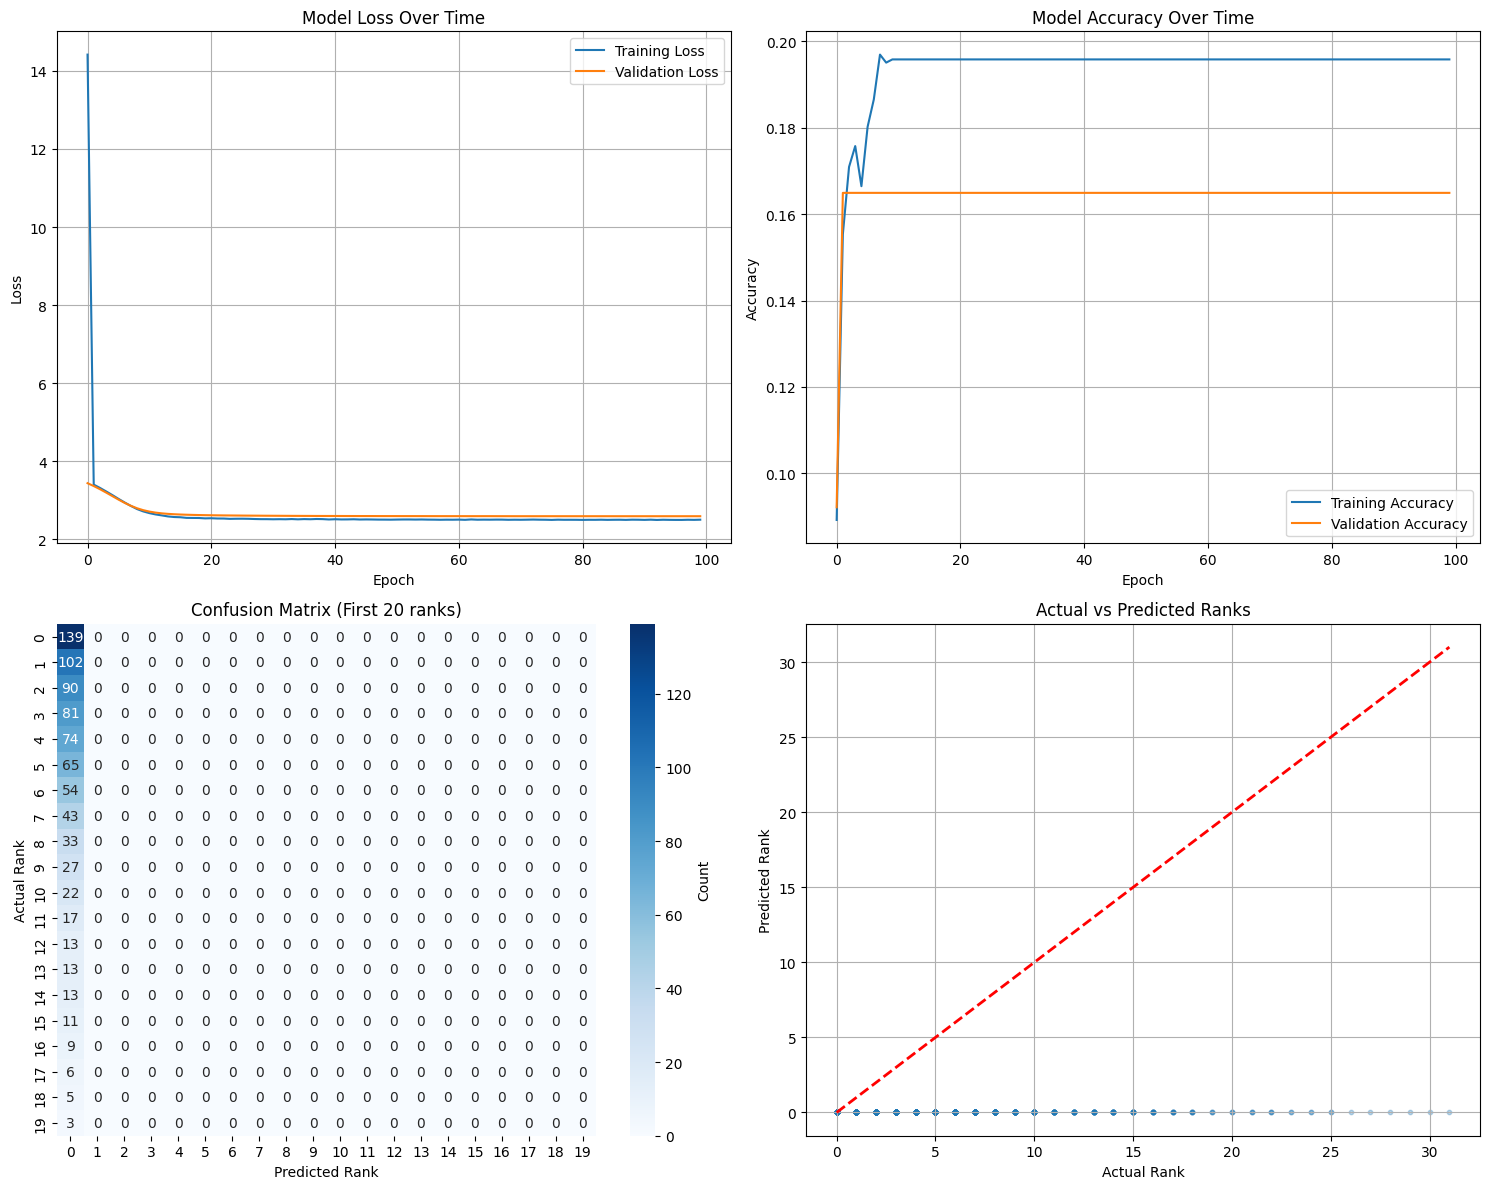


Error Analysis
Mean error: 5.0583
Median error: 4.0000
Max error: 31.0000
Std error: 5.2577


In [11]:
print("\n" + "=" * 60)
print("STEP 8: Model Evaluation")
print("=" * 60)

# Evaluate on test set
test_loss, test_accuracy = lstm_model.evaluate(
    [X_loc_test, X_part_test, X_zone_test, X_feat_test],
    y_test,
    verbose=0
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_probs = lstm_model.predict(
    [X_loc_test, X_part_test, X_zone_test, X_feat_test],
    verbose=0
)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))

# Additional metrics
mae = mean_absolute_error(y_test_labels, y_pred)
print(f"\nMean Absolute Error: {mae:.4f}")

within_1 = np.mean(np.abs(y_test_labels - y_pred) <= 1)
within_2 = np.mean(np.abs(y_test_labels - y_pred) <= 2)
print(f"Accuracy within ±1 rank: {within_1:.4f}")
print(f"Accuracy within ±2 ranks: {within_2:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training History - Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Model Loss Over Time')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Training History - Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Model Accuracy Over Time')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Confusion Matrix (show subset if too large)
if cm.shape[0] > 20:
    cm_display = cm[:20, :20]
    title_suffix = " (First 20 ranks)"
else:
    cm_display = cm
    title_suffix = ""
    
sns.heatmap(cm_display, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0], cbar_kws={'label': 'Count'})
axes[1, 0].set_xlabel('Predicted Rank')
axes[1, 0].set_ylabel('Actual Rank')
axes[1, 0].set_title(f'Confusion Matrix{title_suffix}')

# Plot 4: Actual vs Predicted
axes[1, 1].scatter(y_test_labels, y_pred, alpha=0.3, s=10)
axes[1, 1].plot([y_test_labels.min(), y_test_labels.max()], 
                [y_test_labels.min(), y_test_labels.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Rank')
axes[1, 1].set_ylabel('Predicted Rank')
axes[1, 1].set_title('Actual vs Predicted Ranks')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Error analysis
print("\n" + "=" * 60)
print("Error Analysis")
print("=" * 60)

errors = np.abs(y_test_labels - y_pred)
print(f"Mean error: {errors.mean():.4f}")
print(f"Median error: {np.median(errors):.4f}")
print(f"Max error: {errors.max():.4f}")
print(f"Std error: {errors.std():.4f}")


# ==================== STEP 9: Prediction Function ====================

In [12]:
print("\n" + "=" * 60)
print("STEP 9: Creating Prediction Function")
print("=" * 60)

def predict_location_order_enhanced(order_data):
    """
    Predict the picking order for locations with enhanced features
    
    Parameters:
    -----------
    order_data : DataFrame
        DataFrame with columns: LOCATION_ID, PART_ID, QTY, and other features
    
    Returns:
    --------
    DataFrame with location IDs and predicted ranks
    """
    # Create a copy
    data = order_data.copy()
    
    # Add derived features
    data['ZONE'] = data['LOCATION_ID'].str[0]
    data['ORDER_SIZE'] = len(data)
    data['TOTAL_ORDER_QTY'] = data['QTY'].sum()
    
    # Use current time if not provided
    if 'PICK_HOUR' not in data.columns:
        data['PICK_HOUR'] = pd.Timestamp.now().hour
    if 'DAY_OF_WEEK' not in data.columns:
        data['DAY_OF_WEEK'] = pd.Timestamp.now().dayofweek
    
    # Add sequence features
    data['PREV_LOCATION'] = 'NONE'
    data['NEXT_LOCATION'] = 'NONE'
    data['SECONDS_SINCE_LAST_PICK'] = 0
    data['ZONE_CHANGE'] = 0
    
    # Get historical average rank for each location
    data['LOCATION_AVG_RANK'] = data['LOCATION_ID'].map(
        df.groupby('LOCATION_ID')['LOCATION_RANK'].mean().to_dict()
    ).fillna(df['LOCATION_RANK'].mean())
    
    # Encode features
    predictions = []
    
    for idx, row in data.iterrows():
        # Encode location
        if row['LOCATION_ID'] in le_location.classes_:
            loc_enc = le_location.transform([row['LOCATION_ID']])[0]
        else:
            loc_enc = 0
        
        # Encode part
        if row['PART_ID'] in le_part.classes_:
            part_enc = le_part.transform([row['PART_ID']])[0]
        else:
            part_enc = 0
        
        # Encode zone
        if row['ZONE'] in le_zone.classes_:
            zone_enc = le_zone.transform([row['ZONE']])[0]
        else:
            zone_enc = 0
        
        # Prepare sequences (all locations in order)
        loc_seq = [loc_enc] * max_sequence_length
        part_seq = [part_enc] * max_sequence_length
        zone_seq = [zone_enc] * max_sequence_length
        
        # Scale numerical features
        numerical_vals = scaler.transform([[
            row['QTY'],
            row['ORDER_SIZE'],
            row['TOTAL_ORDER_QTY'],
            row['PICK_HOUR'],
            row['DAY_OF_WEEK'],
            row['SECONDS_SINCE_LAST_PICK'],
            row['LOCATION_AVG_RANK']
        ]])[0]
        
        # Create feature vector
        feature_vec = np.concatenate([
            numerical_vals,
            [0, zone_enc, 0, 0, 0, idx]  # Additional encoded features
        ])
        
        # Predict
        pred_probs = lstm_model.predict(
            [
                np.array([loc_seq]),
                np.array([part_seq]),
                np.array([zone_seq]),
                np.array([feature_vec])
            ],
            verbose=0
        )[0]
        
        predicted_rank = np.argmax(pred_probs) + 1
        confidence = pred_probs.max()
        
        predictions.append({
            'LOCATION_ID': row['LOCATION_ID'],
            'PART_ID': row['PART_ID'],
            'QTY': row['QTY'],
            'ZONE': row['ZONE'],
            'PREDICTED_RANK': predicted_rank,
            'CONFIDENCE': confidence
        })
    
    # Create result dataframe
    result_df = pd.DataFrame(predictions)
    result_df = result_df.sort_values('PREDICTED_RANK').reset_index(drop=True)
    result_df['SUGGESTED_ORDER'] = range(1, len(result_df) + 1)
    
    return result_df

print("✓ Enhanced prediction function created successfully")



STEP 9: Creating Prediction Function
✓ Enhanced prediction function created successfully


# ==================== STEP 10: Example Predictions ====================

In [17]:
print("\n" + "=" * 60)
print("STEP 10: Example Predictions")
print("=" * 60)

# Get a sample order
sample_order_id = df['CUST_ORDER_ID'].unique()[0]
sample_order = df[df['CUST_ORDER_ID'] == sample_order_id].copy()

print(f"\nSample Order: {sample_order_id}")
print(f"Number of locations: {len(sample_order)}")

print("\nActual Order:")
print(sample_order[['LOCATION_ID', 'PART_ID', 'QTY', 'ZONE', 'LOCATION_RANK']].sort_values('LOCATION_RANK'))

# Prepare input for prediction
prediction_input = sample_order[['LOCATION_ID', 'PART_ID', 'QTY']].copy()
prediction_input['PICK_HOUR'] = sample_order['PICK_HOUR'].iloc[0]
prediction_input['DAY_OF_WEEK'] = sample_order['DAY_OF_WEEK'].iloc[0]

print("\nPredicted Order:")
predicted_order = predict_location_order_enhanced(prediction_input)


STEP 10: Example Predictions

Sample Order: 008247-1
Number of locations: 1

Actual Order:
     LOCATION_ID     PART_ID       QTY ZONE  LOCATION_RANK
1615    E6496600  1096161009 -0.292087    E              1

Predicted Order:


x:\Projects\Machine Learning\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# ==================== STEP 11: Model Saving ====================

In [ ]:
print("\n" + "=" * 60)
print("STEP 11: Saving Model and Encoders")
print("=" * 60)

# Save model
lstm_model.save('enhanced_location_lstm_model.h5')
print("✓ Model saved as 'enhanced_location_lstm_model.h5'")

# Save encoders and scaler
import pickle

encoders = {
    'location': le_location,
    'part': le_part,
    'zone': le_zone,
    'user': le_user,
    'prev_loc': le_prev_loc,
    'next_loc': le_next_loc,
    'scaler': scaler,
    'max_sequence_length': max_sequence_length
}

with open('model_encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)
print("✓ Encoders saved as 'model_encoders.pkl'")

print("\n" + "=" * 60)
print("ENHANCED LSTM MODEL TRAINING COMPLETE!")
print("=" * 60)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Accuracy within ±1 rank: {within_1:.4f}")
print(f"Accuracy within ±2 ranks: {within_2:.4f}")
print("\nModel uses the following features:")
print("- Location ID, Part ID, Zone")
print("- Quantity, Order Size, Total Order Quantity")
print("- Pick Hour, Day of Week")
print("- Time between picks, Zone changes")
print("- Historical location patterns")
print("- Sequential context (prev/next locations)")
print("=" * 60)